In [3]:
def print_set_sizes(train_X, train_y, test_X, test_y):
    print(f"""
    train_X: {train_X.shape}
    train_y: {train_y.shape}
    test_X: {test_X.shape}
    test_y: {test_y.shape}
    """)

In [68]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

"""
Testing should only be performed on the real dataset.
"""

BASEPATH = "./datasets/preprocessed/"

test_set = {
    "X": pd.read_csv(BASEPATH + "test_X.csv"),
    "y": pd.read_csv(BASEPATH + "test_y.csv")
}

real_train_set = {
    "X": pd.read_csv(BASEPATH + "real_X.csv"),
    "y": pd.read_csv(BASEPATH + "real_y.csv")
}

pseudoreal_train_set = {
    "X": pd.read_csv(BASEPATH + "pseudoreal_X.csv"),
    "y": pd.read_csv(BASEPATH + "pseudoreal_y.csv")
}

synthetic_train_set = {
    "X": pd.read_csv(BASEPATH + "synthetic_X.csv"),
    "y": pd.read_csv(BASEPATH + "synthetic_y.csv")
}


# Initialize LabelEncoder and transform labels
le = LabelEncoder()
test_set["y"] = pd.Series(le.fit_transform(test_set["y"]))
real_train_set["y"] = pd.Series(le.fit_transform(real_train_set["y"]))
pseudoreal_train_set["y"] = pd.Series(le.fit_transform(pseudoreal_train_set["y"]))
synthetic_train_set["y"] = pd.Series(le.fit_transform(synthetic_train_set["y"]))

# print label mappings
print(le.classes_)
print(real_train_set["X"].value_counts())


DATASETS = {
    "real": {
        "X": {
            "train": real_train_set["X"],
            "test": test_set["X"]
        },
        "y": {
            "train": real_train_set["y"],
            "test": test_set["y"]
        }
    },
    "pseudoreal": {
        "X": {
            "train": pseudoreal_train_set["X"],
            "test": test_set["X"]
        },
        "y": {
            "train": pseudoreal_train_set["y"],
            "test": test_set["y"]
        }
    },
    "real+synthetic": {
        "X": {
            "train": synthetic_train_set["X"],
            "test": test_set["X"]
        },
        "y": {
            "train": synthetic_train_set["y"],
            "test": test_set["y"]
        }
    }
}

DATASETS

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
Age        Height     family_history_with_overweight  FAVC  SMOKE  SCC  CAEC  CALC  FCVC  NCP  CH2O  FAF  TUE  MTRANS_Automobile  MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  Gender_Male
-0.349993  -0.702988  0.0                             1.0   0.0    0.0  0.0   1.0   2.0   1.0  3.0   1.0  0.0  0.0                0.0          0.0               1.0                           0.0             1.0            4
 0.226644  -1.216482  0.0                             1.0   0.0    0.0  1.0   1.0   2.0   1.0  2.0   2.0  0.0  0.0                0.0          0.0               1.0                           0.0             0.0            2
-0.205834   0.015903  1.0                             1.0   0.0    0.0  1.0   1.0   2.0   3.0  2.0   1.0  1.0  0.0                0.0          0.0               1.0                           0.0 

/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-v

{'real': {'X': {'train':           Age    Height  family_history_with_overweight  FAVC  SMOKE  SCC  \
   0   -0.494152  2.994169                             1.0   1.0    0.0  0.0   
   1   -0.782471 -0.702988                             1.0   1.0    0.0  0.0   
   2   -0.205834 -1.935374                             1.0   0.0    0.0  0.0   
   3    1.524078 -0.086795                             0.0   1.0    0.0  0.0   
   4   -0.205834  1.556386                             1.0   1.0    0.0  1.0   
   ..        ...       ...                             ...   ...    ...  ...   
   376 -0.061674  1.350988                             0.0   1.0    0.0  0.0   
   377 -0.782471  0.632096                             0.0   1.0    0.0  0.0   
   378 -1.070789  1.350988                             1.0   1.0    0.0  0.0   
   379 -0.061674 -0.394892                             1.0   1.0    0.0  0.0   
   380 -0.782471 -1.421880                             0.0   1.0    0.0  0.0   
   
        CAEC  

In [ ]:
from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import numpy as np
from time import time
from sklearn.linear_model import RidgeClassifier
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def train_evaluate_classifiers(X_train, y_train, X_test, y_test, random_state=42):
    """
    Train and evaluate multiple classifiers using 5-fold cross validation
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training labels
    X_test : pd.DataFrame
        Test features
    y_test : pd.Series
        Test labels
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing results for each classifier
    """
    
    # Define classifiers
    classifiers = {
        "SVC": {
                "model": Pipeline([
                    ('scaler', StandardScaler()),
                    ('svc', SVC(random_state=random_state, max_iter=2000, tol=1e-4))
                ]),
                "params": {
                    'svc__C': np.logspace(-3, 1, 6),
                    'svc__kernel': ['linear', 'rbf'],
                    'svc__gamma': ['scale', 'auto']
                }
        },
        "RidgeClassifier": {
                "model": RidgeClassifier(
                    random_state=random_state,
                    max_iter=1000,
                    tol=1e-4,
                ),
                "params": {
                    'alpha': np.logspace(-3, 3, 7),
                    'solver': ['auto', 'sag', 'lsqr'],
                    'class_weight': [None, 'balanced']
                }
            },
        "XGBoost": {
            "model": XGBClassifier(
                random_state=random_state, 
                eval_metric='mlogloss'
            ),
            "params": {
                'max_depth': np.linspace(3, 11, dtype=int),
                'learning_rate': np.linspace(0.1, 0.3, 10),
                'n_estimators': np.arange(100, 1000, 100),
                'gamma': np.linspace(0, 5, 6),
            }
        },
        "KNN": {
            "model": KNeighborsClassifier(),
            "params": {
                'n_neighbors': np.arange(1, 31),
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'leaf_size': np.arange(10, 100, 10),
                "p": [1, 2]
            }
        },
        "LGBM": {
            "model": LGBMClassifier(random_state=random_state, verbosity=-1, verbose=-1),
            "params": {
                'learning_rate': np.linspace(0.01, 0.3, 10),
                'n_estimators': np.arange(100, 1000, 100),
                'max_depth': np.arange(3, 11, dtype=int),
                'num_leaves': np.arange(20, 150, 20),
                'subsample': np.linspace(0.5, 1.0, 6),
                'colsample_bytree': np.linspace(0.5, 1.0, 6),
                'reg_alpha': np.linspace(0, 1, 5),
                'reg_lambda': np.linspace(0, 1, 5),
                'boosting_type': ['gbdt', 'dart'],
            }
        },
    }
    
    # Define custom scoring functions with zero_division=0
    def precision_scorer(y_true, y_pred):
        return precision_score(y_true, y_pred, average='macro', zero_division=0)

    def recall_scorer(y_true, y_pred):
        return recall_score(y_true, y_pred, average='macro', zero_division=0)

    def f1_scorer(y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Create scorers
    scoring = {
        'accuracy': 'accuracy',
        'precision_macro': make_scorer(precision_scorer),
        'recall_macro': make_scorer(recall_scorer),
        'f1_macro': make_scorer(f1_scorer)
    }

    results = {}
    
    for name, clf_dict in classifiers.items():
        print(f"Training {name} classifier...")
        # Start timing
        start_time = time()
        
        # Get the model from the dictionary
        clf = clf_dict['model']
        
        # For small datasets or datasets with tiny classes
        if X_train.shape[0] < 500:
            cv = LeaveOneOut()  # Use LOO for very small datasets
        else:
            # Count samples in smallest class
            class_counts = y_train.value_counts()
            min_class_samples = class_counts.min()
            
            # Choose appropriate number of splits based on smallest class
            if min_class_samples < 10:
                n_splits = min(5, min_class_samples)  # Use at most 5 splits, but no more than samples in smallest class
                print(f"Using {n_splits} splits due to small class size ({min_class_samples} samples in smallest class)")
                cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            else:
                cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
        
        # Perform cross-validation with random search
        cv_results = RandomizedSearchCV(clf, 
                                        clf_dict['params'], 
                                        cv=cv, 
                                        scoring=scoring, 
                                        refit='f1_macro', 
                                        n_iter=20,
                                        n_jobs=-1,
                                        random_state=random_state, 
                                        verbose=1)
        cv_results.fit(X_train, y_train)
        
        # Fit on full training data and evaluate on test set
        best_clf = cv_results.best_estimator_
        test_pred_encoded = best_clf.predict(X_test)

        test_scores = precision_recall_fscore_support(y_test.values, test_pred_encoded, average='macro', zero_division=0)
        test_accuracy = accuracy_score(y_test.values, test_pred_encoded)
        
        # Store results
        results[name] = {
            'cv_accuracy': cv_results.cv_results_['mean_test_accuracy'].mean(),
            'cv_accuracy_std': cv_results.cv_results_['std_test_accuracy'].mean(),
            'cv_precision': cv_results.cv_results_['mean_test_precision_macro'].mean(),
            'cv_recall': cv_results.cv_results_['mean_test_recall_macro'].mean(),
            'cv_f1': cv_results.cv_results_['mean_test_f1_macro'].mean(),
            'test_accuracy': test_accuracy,
            'test_precision': test_scores[0],
            'test_recall': test_scores[1],
            'test_f1': test_scores[2],
            'training_time': time() - start_time,
            'fitted_model': best_clf,
            'best_params': cv_results.best_params_
        }
        
        print(f"DONE: {results[name]}")
    
    return results

RESULTS = {}

# Test the function on both real and synthetic datasets
for dataset_name, dataset in DATASETS.items():
    print(f"\nEvaluating on {dataset_name} dataset:")
    
    # Prepare data
    X_train = dataset['X']['train']
    y_train = dataset['y']['train']
    X_test = dataset['X']['test']
    y_test = dataset['y']['test']

    print("Dataset sizes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")
    
    """
    # For synthetic dataset, use only the first 423 test samples to match real dataset
    if dataset_name == 'synthetic':
        X_test = X_test.iloc[:423]
        y_test = y_test.iloc[:423]
    """

    # Train and evaluate
    results = train_evaluate_classifiers(X_train, y_train, X_test, y_test)
    
    # Store results
    RESULTS[dataset_name] = results

    # Print results
    for clf_name, metrics in results.items():
        print(f"\n{clf_name}:")
        print(f"CV Accuracy: {metrics['cv_accuracy']:.3f} (±{metrics['cv_accuracy_std']:.3f})")
        print(f"Test Accuracy: {metrics['test_accuracy']:.3f}")
        print(f"Test F1-Score: {metrics['test_f1']:.3f}")
        print(f"Training Time: {metrics['training_time']:.2f} seconds")

    results_df = pd.DataFrame.from_dict(results, orient='index')
    print(results_df)
    
# Save results to global variable
import pickle
with open("results.pkl", "wb") as f:
    pickle.dump(RESULTS, f)


Evaluating on real dataset:
Dataset sizes:
X_train: (381, 19)
y_train: (381,)
X_test: (96, 19)
y_test: (96,)
Training SVC classifier...
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python

DONE: {'cv_accuracy': np.float64(0.5609075573549258), 'cv_accuracy_std': np.float64(0.02265968749571947), 'cv_precision': np.float64(0.13073134427167193), 'cv_recall': np.float64(0.17597668006596576), 'cv_f1': np.float64(0.1408581691964156), 'test_accuracy': 0.4583333333333333, 'test_precision': 0.2943452380952381, 'test_recall': 0.19888682745825603, 'test_f1': 0.19031090697148426, 'training_time': 1.6394352912902832, 'fitted_model': Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=np.float64(10.0), max_iter=2000, random_state=42,
                     tol=0.0001))]), 'best_params': {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__C': np.float64(10.0)}}
Training RidgeClassifier classifier...
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iven

DONE: {'cv_accuracy': np.float64(0.35545546558704455), 'cv_accuracy_std': np.float64(0.03688253977221796), 'cv_precision': np.float64(0.14366556101847455), 'cv_recall': np.float64(0.15545129870129867), 'cv_f1': np.float64(0.11771007361316896), 'test_accuracy': 0.5729166666666666, 'test_precision': 0.0818452380952381, 'test_recall': 0.14285714285714285, 'test_f1': 0.10406811731315042, 'training_time': 1.0640990734100342, 'fitted_model': RidgeClassifier(alpha=np.float64(100.0), max_iter=1000, random_state=42), 'best_params': {'solver': 'auto', 'class_weight': None, 'alpha': np.float64(100.0)}}
Training XGBoost classifier...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
DONE: {'cv_accuracy': np.float64(0.5604352226720648), 'cv_accuracy_std': np.float64(0.030191326847264166), 'cv_precision': np.float64(0.1476944712769917), 'cv_recall': np.float64(0.18673750257678828), 'cv_f1': np.float64(0.1556008181842524), 'test_accuracy': 0.5, 'test_precision': 0.2205461894902889, 'test

/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


DONE: {'cv_accuracy': np.float64(0.5510829959514171), 'cv_accuracy_std': np.float64(0.038151897784835534), 'cv_precision': np.float64(0.18656432253750133), 'cv_recall': np.float64(0.1925050762729334), 'cv_f1': np.float64(0.1683947133098251), 'test_accuracy': 0.53125, 'test_precision': 0.1917989417989418, 'test_recall': 0.1784786641929499, 'test_f1': 0.17183600713012478, 'training_time': 0.2742424011230469, 'fitted_model': KNeighborsClassifier(algorithm='brute', leaf_size=np.int64(20),
                     n_neighbors=np.int64(7), p=1, weights='distance'), 'best_params': {'weights': 'distance', 'p': 1, 'n_neighbors': np.int64(7), 'leaf_size': np.int64(20), 'algorithm': 'brute'}}
Training LGBM classifier...
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


KeyboardInterrupt: 

In [27]:
for dataset_name, dataset_results in RESULTS.items():
    print(f"Results for {dataset_name.capitalize()} Dataset:\n")
    for clf_name, metrics in dataset_results.items():
        print(f"Classifier: {clf_name}")
        print(f"  CV Accuracy: {metrics['cv_accuracy']:.3f} (±{metrics['cv_accuracy_std']:.3f})")
        print(f"  CV Precision: {metrics['cv_precision']:.3f}")
        print(f"  CV Recall: {metrics['cv_recall']:.3f}")
        print(f"  CV F1-Score: {metrics['cv_f1']:.3f}")
        print(f"  Test Accuracy: {metrics['test_accuracy']:.3f}")
        print(f"  Test F1-Score: {metrics['test_f1']:.3f}")
        print(f"  Training Time: {metrics['training_time']:.2f} seconds")
        print(f"  Best Parameters: {metrics['best_params']}")
        print()

Results for Real Dataset:

Classifier: SVC
  CV Accuracy: 0.559 (±0.016)
  CV Precision: 0.117
  CV Recall: 0.171
  CV F1-Score: 0.134
  Test Accuracy: 0.406
  Test F1-Score: 0.176
  Training Time: 2.23 seconds
  Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': np.float64(100.0)}

Classifier: RidgeClassifier
  CV Accuracy: 0.485 (±0.035)
  CV Precision: 0.139
  CV Recall: 0.163
  CV F1-Score: 0.127
  Test Accuracy: 0.583
  Test F1-Score: 0.197
  Training Time: 0.62 seconds
  Best Parameters: {'solver': 'sag', 'class_weight': None, 'alpha': np.float64(0.1)}

Classifier: XGBoost
  CV Accuracy: 0.565 (±0.018)
  CV Precision: 0.127
  CV Recall: 0.170
  CV F1-Score: 0.136
  Test Accuracy: 0.469
  Test F1-Score: 0.186
  Training Time: 1.49 seconds
  Best Parameters: {'n_estimators': np.int64(600), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.12222222222222223), 'gamma': np.float64(0.0)}

Classifier: KNN
  CV Accuracy: 0.547 (±0.025)
  CV Precision: 0.170
  CV Recall: 0.1

KeyError: 'cv_accuracy'

In [26]:
markdown_text = "# Baseline Classifier Evaluation Results\n\n"
markdown_text += """
> The following table shows the results of the baseline classifiers on the real and synthetic datasets.
> The results are based on 5-fold cross-validation with default parameters.
> The results are displayed in descending order of F1-Score.

"""

# make a markdown table from the results
for dataset_name, results in RESULTS.items():
    markdown_text += f"## {dataset_name.capitalize()} Dataset\n\n"
    
    # Create table header
    markdown_text += "| Classifier | CV Accuracy | Test Accuracy | Test F1-Score | Training Time (s) | Efficiency (F1/s) |\n"
    markdown_text += "|------------|-------------|---------------|---------------|------------------| ------------------ |\n"
    
    # Order by f1-score
    results_ord = {k: v for k, v in sorted(results.items(), key=lambda item: item[1]['test_f1'], reverse=True)}

    # Add each classifier's results as a row
    for clf_name, metrics in results_ord.items():
        training_time_to_f1_ratio = metrics['test_f1'] / metrics['training_time']
        markdown_text += f"| {clf_name} | {metrics['cv_accuracy']:.3f} (±{metrics['cv_accuracy_std']:.3f}) | "
        markdown_text += f"{metrics['test_accuracy']:.3f} | {metrics['test_f1']:.3f} | {metrics['training_time']:.2f} | {training_time_to_f1_ratio:.2f} |\n"
    markdown_text += "\n"  # Add space between dataset tables

# Write to file
with open('classification_results.md', 'w') as f:
    f.write(markdown_text)

print("Results have been written to classification_results.md")

KeyError: 'test_f1'

Top 5 models selected for ensemble:
1. real+synthetic - KNN: F1=0.366
2. real+synthetic - SVC: F1=0.352
3. pseudoreal - SVC: F1=0.328
4. pseudoreal - KNN: F1=0.304
5. real+synthetic - LGBM: F1=0.278
Using hard voting method


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in 


VotingClassifier Performance:
  Accuracy: 0.479
  F1-Score: 0.187
  Precision: 0.211
  Recall: 0.186

StackingClassifier Performance:
  Accuracy: 0.531
  F1-Score: 0.139
  Precision: 0.157
  Recall: 0.156

VotingClassifier Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.29      0.29      0.29         7
      Normal_Weight       0.59      0.75      0.66        55
 Overweight_Level_I       0.00      0.00      0.00         9
Overweight_Level_II       0.00      0.00      0.00         2
     Obesity_Type_I       0.00      0.00      0.00         1
    Obesity_Type_II       0.10      0.09      0.10        11
   Obesity_Type_III       0.50      0.18      0.27        11

           accuracy                           0.48        96
          macro avg       0.21      0.19      0.19        96
       weighted avg       0.43      0.48      0.44        96


StackingClassifier Classification Report:
                     precision    re

/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

,Model,Accuracy,F1-Score,Precision,Recall,Time
0,VotingClassifier,0.479167,0.186987,0.211417,0.186271,1.604636
1,StackingClassifier,0.531250,0.139408,0.156650,0.156133,4.904229
2,real+synthetic_KNN,0.479167,0.366209,NaN,NaN,NaN
3,real+synthetic_SVC,0.500000,0.351623,NaN,NaN,NaN
4,pseudoreal_SVC,0.510417,0.327946,NaN,NaN,NaN
5,pseudoreal_KNN,0.364583,0.303816,NaN,NaN,NaN
6,real+synthetic_LGBM,0.260417,0.277633,NaN,NaN,NaN



Best ensemble classifier (voting_ensemble) saved to 'voting_ensemble_classifier.pkl'


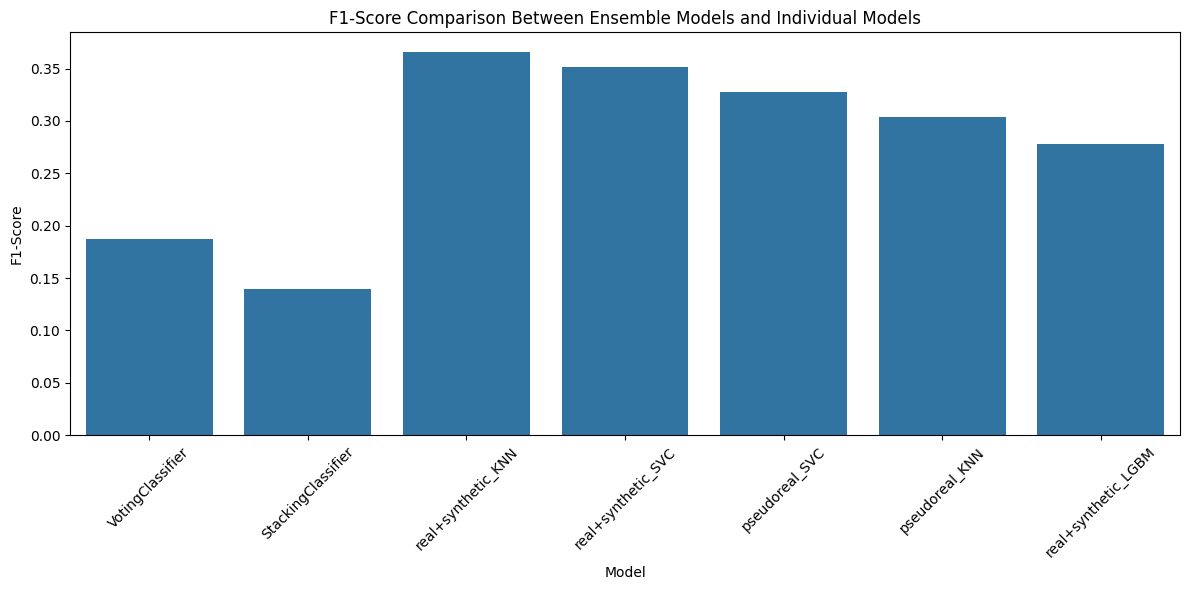

In [53]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from time import time
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# No need to reload RESULTS as it's already loaded in the notebook
with open("results.pkl", "rb") as f:
    RESULTS = pickle.load(f)

# Collect all models and their metrics across all datasets
all_models = []
for dataset_name, dataset_results in RESULTS.items():
    for clf_name, metrics in dataset_results.items():
        all_models.append({
            'dataset': dataset_name,
            'classifier': clf_name,
            'model': metrics['fitted_model'],
            'test_f1': metrics['test_f1'],
            'test_accuracy': metrics['test_accuracy'],
            'training_time': metrics['training_time']
        })

# Sort models by F1-score (descending)
all_models_sorted = sorted(all_models, key=lambda x: x['test_f1'], reverse=True)

# Select top 5 models 
top_models = all_models_sorted[:5]
print("Top 5 models selected for ensemble:")
for i, model in enumerate(top_models):
    print(f"{i+1}. {model['dataset']} - {model['classifier']}: F1={model['test_f1']:.3f}")

# Create estimators for Voting Classifier
estimators = [(f"{model['dataset']}_{model['classifier']}", model['model']) for model in top_models]

# Create ensemble - try soft voting for classifiers that support predict_proba
try:
    # Check which models support predict_proba
    support_proba = []
    for name, model in estimators:
        try:
            if hasattr(model, 'predict_proba'):
                support_proba.append(True)
            else:
                support_proba.append(False)
        except:
            support_proba.append(False)
    
    # Use soft voting if all models support it, otherwise hard
    voting_method = 'soft' if all(support_proba) else 'hard'
    print(f"Using {voting_method} voting method")
    
    # Create weighted ensemble
    weights = [model['test_f1'] for model in top_models]
    ensemble = VotingClassifier(estimators=estimators, voting=voting_method, weights=weights)
except:
    print("Falling back to hard voting without weights")
    ensemble = VotingClassifier(estimators=estimators, voting='hard')

# Prepare also a Stacking Classifier
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=RESULTS['real+synthetic']['KNN']['fitted_model'],
    cv=5
)

# Get test data from the real dataset
X_test = DATASETS["real"]["X"]["test"]
y_test = DATASETS["real"]["y"]["test"]
X_train = DATASETS["real"]["X"]["train"]
y_train = DATASETS["real"]["y"]["train"]

# Fit and evaluate VotingClassifier
start_time = time()
ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)
ensemble_time = time() - start_time

# Fit and evaluate StackingClassifier
start_time = time()
stacking.fit(X_train, y_train)
stacking_pred = stacking.predict(X_test)
stacking_time = time() - start_time

# Calculate metrics
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_precision, ensemble_recall, ensemble_f1, _ = precision_recall_fscore_support(
    y_test, ensemble_pred, average='macro'
)

stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_precision, stacking_recall, stacking_f1, _ = precision_recall_fscore_support(
    y_test, stacking_pred, average='macro'
)

print("\nVotingClassifier Performance:")
print(f"  Accuracy: {ensemble_accuracy:.3f}")
print(f"  F1-Score: {ensemble_f1:.3f}")
print(f"  Precision: {ensemble_precision:.3f}")
print(f"  Recall: {ensemble_recall:.3f}")

print("\nStackingClassifier Performance:")
print(f"  Accuracy: {stacking_accuracy:.3f}")
print(f"  F1-Score: {stacking_f1:.3f}")
print(f"  Precision: {stacking_precision:.3f}")
print(f"  Recall: {stacking_recall:.3f}")

# Display detailed classification reports
class_names = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
               'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

print("\nVotingClassifier Classification Report:")
print(classification_report(y_test, ensemble_pred, target_names=class_names))

print("\nStackingClassifier Classification Report:")
print(classification_report(y_test, stacking_pred, target_names=class_names))

# Compare performance with individual models
results_comparison = pd.DataFrame([
    {'Model': 'VotingClassifier', 'Accuracy': ensemble_accuracy, 'F1-Score': ensemble_f1, 
     'Precision': ensemble_precision, 'Recall': ensemble_recall, 'Time': ensemble_time},
    {'Model': 'StackingClassifier', 'Accuracy': stacking_accuracy, 'F1-Score': stacking_f1, 
     'Precision': stacking_precision, 'Recall': stacking_recall, 'Time': stacking_time}
])

# Use concat instead of append (which is deprecated)
for model in top_models:
    model_df = pd.DataFrame({
        'Model': [f"{model['dataset']}_{model['classifier']}"],
        'Accuracy': [model['test_accuracy']],
        'F1-Score': [model['test_f1']],
        'Precision': [None],  # We don't have this data readily available
        'Recall': [None]      # We don't have this data readily available
    })
    results_comparison = pd.concat([results_comparison, model_df], ignore_index=True)

print("\nModel Comparison:")
display(results_comparison)

# Save the best ensemble model
best_ensemble = ensemble if ensemble_f1 > stacking_f1 else stacking
best_name = "voting_ensemble" if ensemble_f1 > stacking_f1 else "stacking_ensemble"
with open(f'{best_name}_classifier.pkl', 'wb') as f:
    pickle.dump(best_ensemble, f)
print(f"\nBest ensemble classifier ({best_name}) saved to '{best_name}_classifier.pkl'")

# Plot performance comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-Score', data=results_comparison)
plt.title('F1-Score Comparison Between Ensemble Models and Individual Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

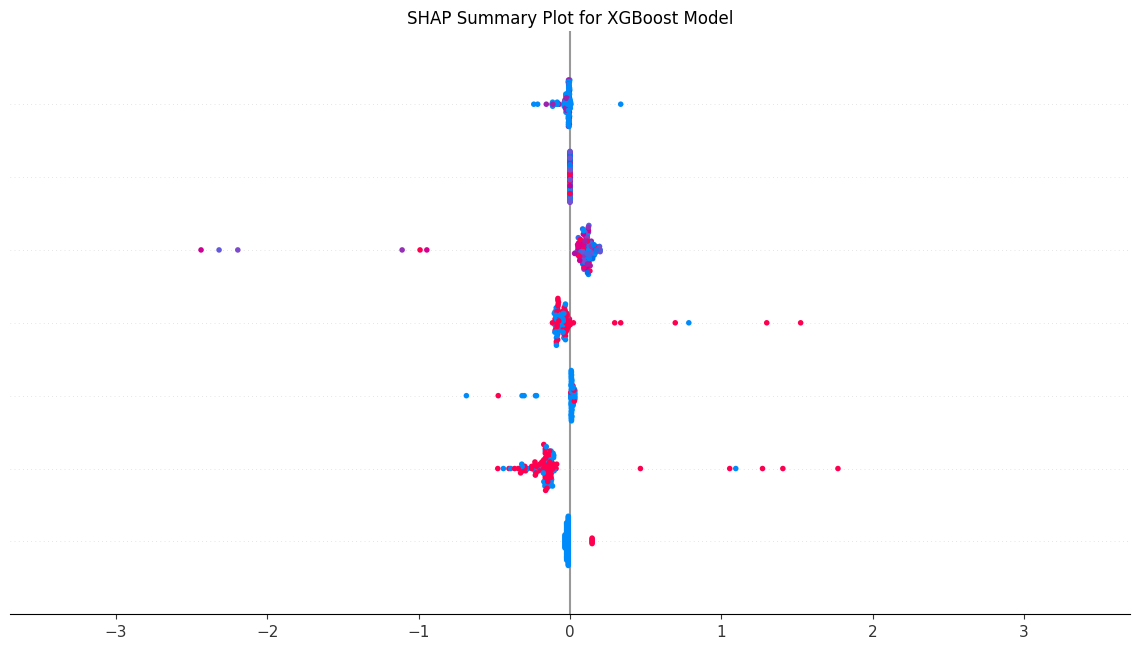

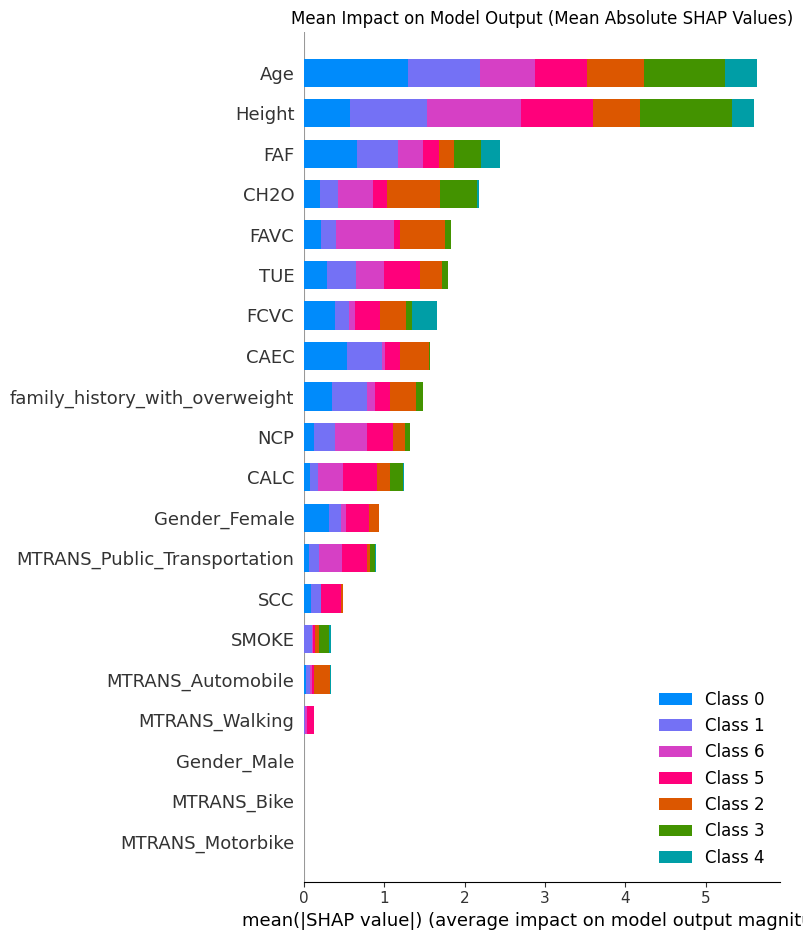

In [ ]:
import shap
import matplotlib.pyplot as plt

# Get the XGBoost model and sample data
xgb_model = RESULTS['real']['XGBoost']['fitted_model']

# Create a SHAP explainer for the model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for a subset of training data (100 samples for visualization)
shap_values = explainer.shap_values(X_train[:100])

# Create summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train[:100], feature_names=X_train.columns, show=False)
plt.title('SHAP Summary Plot for XGBoost Model')
plt.tight_layout()
plt.show()

# Bar plot of mean absolute SHAP values
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_train[:100], feature_names=X_train.columns, plot_type="bar", show=False)
plt.title('Mean Impact on Model Output (Mean Absolute SHAP Values)')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe from the results
data = []
for dataset_name, results in RESULTS.items():
    for clf_name, metrics in results.items():
        data.append({
            'Dataset': dataset_name.capitalize(),
            'Classifier': clf_name,
            'CV Accuracy': metrics['cv_accuracy'],
            'Test Accuracy': metrics['test_accuracy'],
            'Test F1-Score': metrics['test_f1']
        })

df_metrics = pd.DataFrame(data)

# Create a grouped bar plot
plt.figure(figsize=(15, 8))
metrics = ['CV Accuracy', 'Test Accuracy', 'Test F1-Score']
x = np.arange(len(df_metrics['Classifier'].unique()))
width = 0.25

for i, dataset in enumerate(df_metrics['Dataset'].unique()):
    dataset_data = df_metrics[df_metrics['Dataset'] == dataset]
    plt.bar(x + i*width, dataset_data['Test F1-Score'], 
            width, label=f'{dataset}', alpha=0.8)

plt.xlabel('Classifier')
plt.ylabel('F1-Score')
plt.title('Classifier Performance Comparison Across Datasets')
plt.xticks(x + width, df_metrics['Classifier'].unique(), ha='center')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'RESULTS' is not defined

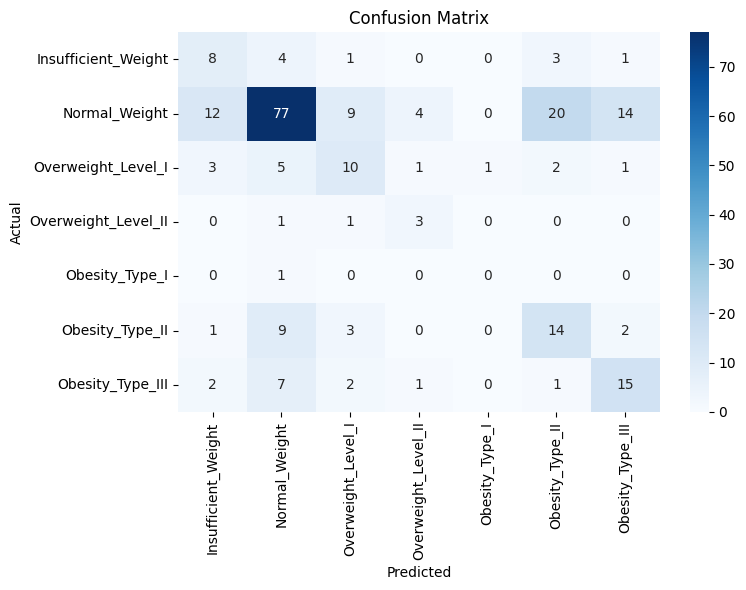

,precision,recall,f1-score,support
Insufficient_Weight,0.307692,0.470588,0.372093,17.000000
Normal_Weight,0.740385,0.566176,0.641667,136.000000
Overweight_Level_I,0.384615,0.434783,0.408163,23.000000
Overweight_Level_II,0.333333,0.600000,0.428571,5.000000
Obesity_Type_I,0.000000,0.000000,0.000000,1.000000
Obesity_Type_II,0.350000,0.482759,0.405797,29.000000
Obesity_Type_III,0.454545,0.535714,0.491803,28.000000
accuracy,0.531381,0.531381,0.531381,0.531381
macro avg,0.367224,0.441431,0.392585,239.000000
weighted avg,0.582900,0.531381,0.546701,239.000000


In [ ]:
# Evaluate the RandomForest model on real+synthetic dataset
# Shows confusion matrix 
# Showsand per-class F1/precision/recall (imbalanced)

def evaluate_model_with_report(model, X_test, y_test, class_names):
    from sklearn.metrics import confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    return pd.DataFrame(report).transpose()

model = RESULTS["real+synthetic"]["RandomForest"]["fitted_model"]
X_test = DATASETS["real+synthetic"]["X"]["test"]
y_test = DATASETS["real+synthetic"]["y"]["test"]

class_names = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
               'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

report_df = evaluate_model_with_report(model, X_test, y_test, class_names)
display(report_df)



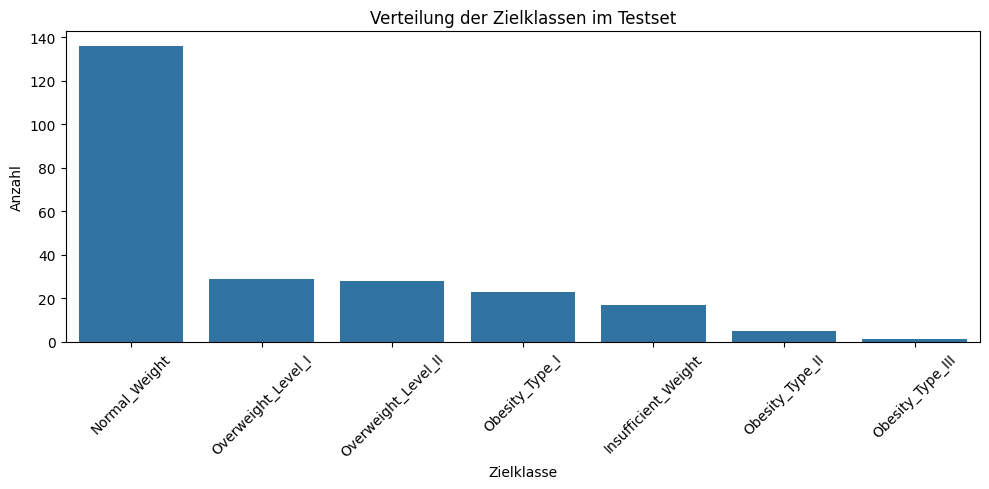

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the test labels
y_test = DATASETS["real+synthetic"]["y"]["test"]

# LabelEncoder initialisieren und fitten
label_encoder = LabelEncoder()
label_encoder.fit([
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
])

# Zielklassen im Testset dekodieren
y_test_named = pd.Series(label_encoder.inverse_transform(y_test), name="Klasse")

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(x=y_test_named, order=y_test_named.value_counts().index)
plt.title("Verteilung der Zielklassen im Testset")
plt.xticks(rotation=45)
plt.xlabel("Zielklasse")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a441f35e-4b4c-4c50-b56a-1aea6b800ed8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>
